# Projet MAP473D : Simulation Moléculaire #
### Barthélémy Bulteau - Smail El Hafdi ###

Imports des libraires nécessaires au projet :

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

Représentation graphique de la fonction potentiel $V(x) = \frac{x^4}{4} + \frac{x^3}{3} - \frac{x^2}{2}$ et de ses minimas situés en $x_1 \approx -1.618$ et $x_2 \approx 0.618$.

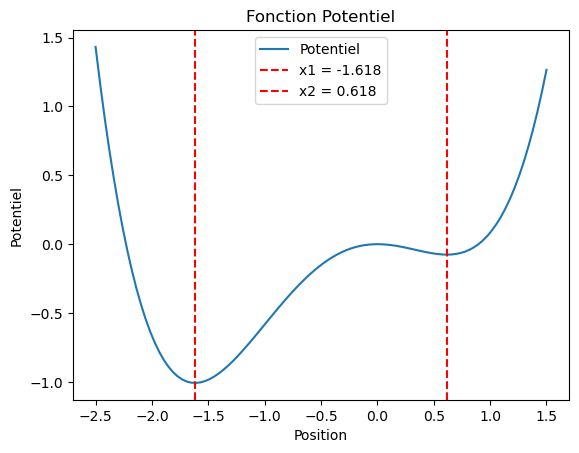

In [30]:
# Fonction potentiel
def V(x):
    return (3*x**4 + 4*x**3 - 6*x**2)/12

# Dérivée
def Vprime(x):
    return x**3 + x**2 - x

# Dérivée seconde
def Vseconde(x):
    return 3*x**2 + 2*x - 1

# Abscisses des minimas
x1 = (-1-np.sqrt(5))/2
x2 = (-1+np.sqrt(5))/2
x0 = x1+0.1
z = 0
delaV = V(z) - V(x1)

# représentation graphique
x = np.linspace(-2.5, 1.5, 100)
plt.plot(x, V(x), label='Potentiel')
plt.title("Fonction Potentiel")
# plot vertical line for x1 and x2
plt.axvline(x1, color='r', linestyle='--', label=f'x1 = {round(x1, 3)}')
plt.axvline(x2, color='r', linestyle='--', label=f'x2 = {round(x2, 3)}')
plt.xlabel("Position")
plt.ylabel("Potentiel")
plt.legend()
plt.show()

### Question 1 ###

Implémentation de la Méthode de Monte-Carlo Naïve  pour le calcul de $\mathbb{P}\left(R \right )$ avec $R=\left \{ \tau_{2} < \tau_{1} \right \}$.

In [3]:
# Calcul de la proba de R={t2 < t1}, P(R) = E(1{t2-t1}) par méthode de Monte-Carlo naïve
def MC_naif(X0, h, epsilon, N):
    E = 0
    global x1
    global x2
    sigma = np.sqrt(2*epsilon*h)

    for _ in range(N):
        Xn = X0
        while Xn >= x1 and Xn <= x2:
            Xn = Xn - Vprime(Xn)*h + sigma*np.random.randn()
        if Xn > x2:
            E += 1

    return E/N

In [4]:
# Exemple d'une estimation
print("P(R) = {}".format(MC_naif(x1+0.1, 1, 1, 100000)))

P(R) = 0.1421


Influence du pas de temps $h$ sur la valeur de $\mathbb{P}\left(R \right )$ calculée :

Barres d'erreur

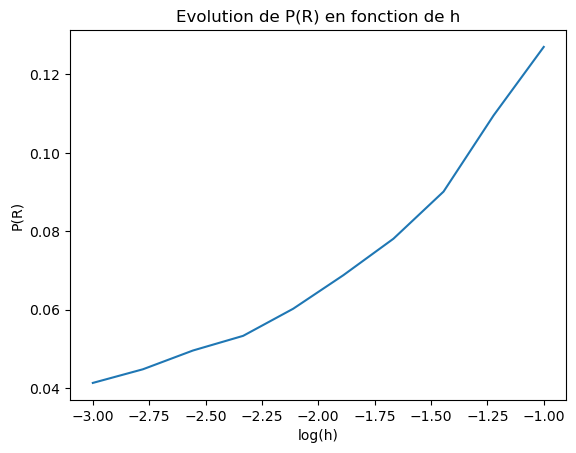

In [5]:
N = int(1e5)
epsilon = 2
h_list = np.logspace(-3, -1, 10)
estimations = [MC_naif(x1+0.1, h, epsilon, N) for h in h_list]

plt.plot(np.log10(h_list), estimations)
plt.title("Evolution de P(R) en fonction de h")
plt.xlabel("log(h)")
plt.ylabel("P(R)")
plt.show()

Influence du paramètre $\epsilon$ sur la valeur de $\mathbb{P}\left(R \right )$ :

logP = f(1/epsilon)

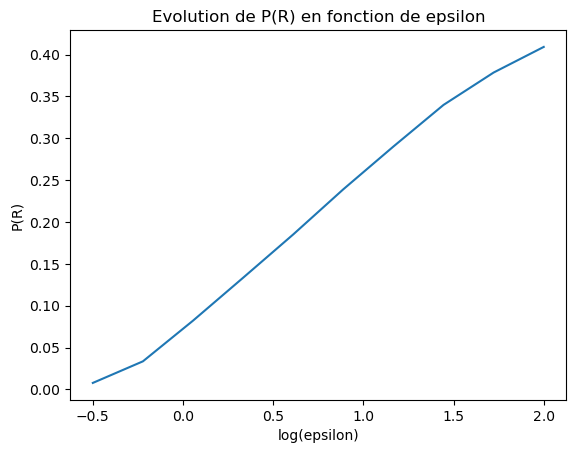

In [6]:
N = int(1e5)
epsilon_list = np.logspace(-0.5, 2, 10)
h = 0.1
estimations = [MC_naif(x1+0.1, h, epsilon, N) for epsilon in epsilon_list]

plt.plot(np.log10(epsilon_list), estimations)
plt.title("Evolution de P(R) en fonction de epsilon")
plt.xlabel("log(epsilon)")
plt.ylabel("P(R)")
plt.show()

(on remarque une décroissance exponentielle)

Quelques exemples de trajectoires :

Plutot tracer des trajectoires reactives (on devrait trouver)

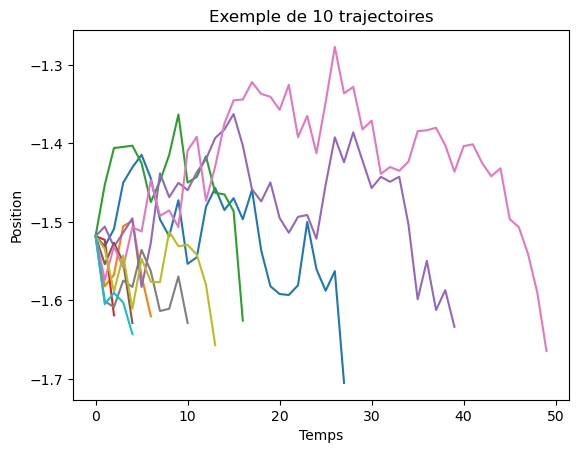

In [7]:
def simulation_trajectoire(X0, h, sigma):
    # simulation d'une trajectoire
    Xn = X0
    traj = [X0]
    while Xn >= x1 and Xn <= x2:
        Xn = Xn - Vprime(Xn)*h + sigma*np.random.randn()
        traj.append(Xn)
    return np.array(traj)

h = 0.01
epsilon = 0.1
sigma = np.sqrt(2*epsilon*h)

for _ in range(10):
    traj = simulation_trajectoire(x1+0.1, h, sigma)
    plt.plot(np.arange(len(traj)), traj)

plt.title("Exemple de 10 trajectoires")
plt.xlabel("Temps")
plt.ylabel("Position")
plt.show()

Distribution de la longueur de telles trajectoires :

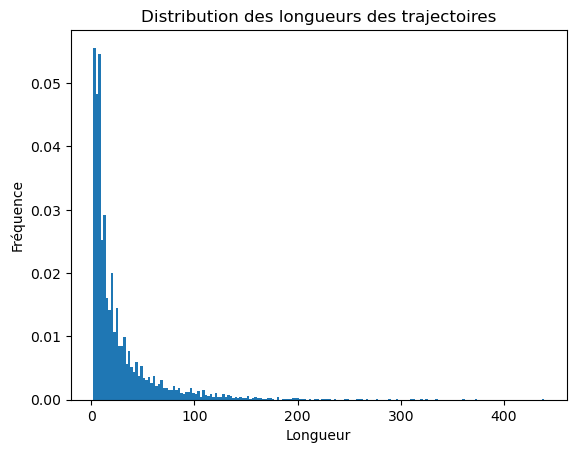

In [8]:
longueurs = [len(simulation_trajectoire(x1+0.1, h, sigma)) for _ in range(10000)]
plt.hist(longueurs, bins='auto', density=True)
plt.title("Distribution des longueurs des trajectoires")
plt.xlabel("Longueur")
plt.ylabel("Fréquence")
plt.show()

### Question 2 ###

Calcul de  $\mathbb{P}\left(R \right )$ par l'algorithme AMS :

In [9]:
def K(trajectoires):
    # retourne le plus petit maximum des trajectoires
    return np.amin([np.amax(traj) for traj in trajectoires])

def I(trajectoires, K_value):
    # retourne les indices des trajectoires dont le maximum est K_value
    return [i for i, traj in enumerate(trajectoires) if abs(np.amax(traj) - K_value) < 1e-10]

def estimateur_AMS(X0, M, h, epsilon, debug=False):
    # variables
    global x2
    trajectoires = []
    I_q = []
    K_q = 0
    sigma = np.sqrt(2*epsilon*h)
    p_estim = 1

    # simulation initiale
    trajectoires = [simulation_trajectoire(X0, h, sigma) for _ in range(M)]
    K_q = K(trajectoires)
    I_q = I(trajectoires, K_q)
    p_estim *= 1 - len(I_q)/M

    q = 0
    while K_q < x2:
        if debug:
            print("Iteration n°{} \t K_q/x2 = {}".format(q, K_q/x2))

        # (i) Branchement
        indices = list(set(range(M)) - set(I_q))
        for m in I_q:
            p = np.random.choice(indices)
            idx = np.where(trajectoires[p] > K_q)[0][0]
            trajectoires[m] = np.concatenate((trajectoires[p][:idx], simulation_trajectoire(trajectoires[p][idx], h, sigma)))

        # (ii) Calcul du niveau
        K_q = K(trajectoires)
        I_q = I(trajectoires, K_q)
        p_estim *= 1 - len(I_q)/M

        q += 1

    return p_estim

Vérification de la cohérence de l'estimation avec la méthode de Monte-Carlo naïve :

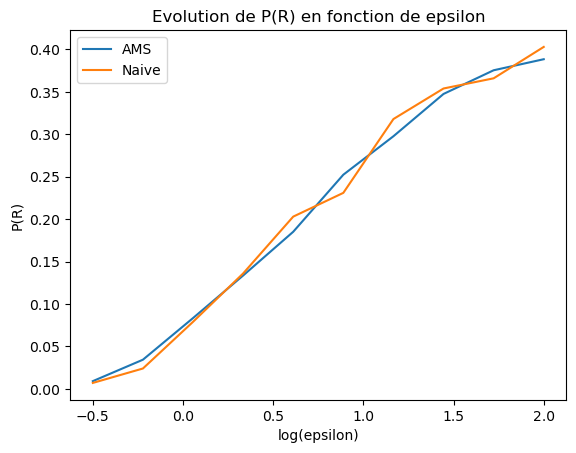

In [10]:
h = 0.1
epsilon_list = np.logspace(-0.5, 2, 10)
M = 1000
N = 1000
estimations_AMS = [estimateur_AMS(x1+0.1, M, h, epsilon) for epsilon in epsilon_list]
estimations_naives = [MC_naif(x1+0.1, h, epsilon, N) for epsilon in epsilon_list]

plt.plot(np.log10(epsilon_list), estimations_AMS, label='AMS')
plt.plot(np.log10(epsilon_list), estimations_naives, label='Naive')
plt.title("Evolution de P(R) en fonction de epsilon")
plt.xlabel("log(epsilon)")
plt.ylabel("P(R)")
plt.legend()
plt.show()

Influence du pas de temps $h$ :

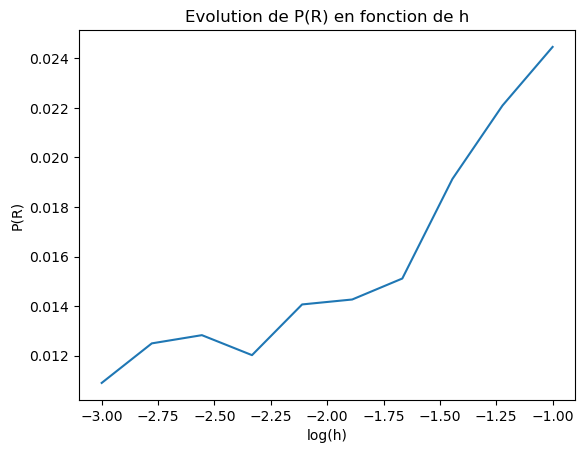

In [11]:
M = int(1e2)
epsilon = 0.5
h_list = np.logspace(-3, -1, 10)
estimations = [np.mean([estimateur_AMS(x1+0.1, M, h, epsilon) for _ in range(20)]) for h in h_list]

plt.plot(np.log10(h_list), estimations)
plt.title("Evolution de P(R) en fonction de h")
plt.xlabel("log(h)")
plt.ylabel("P(R)")
plt.show()

Tracé des trajectoires produites par l'algorithme AMS et affichage de leur distribution :

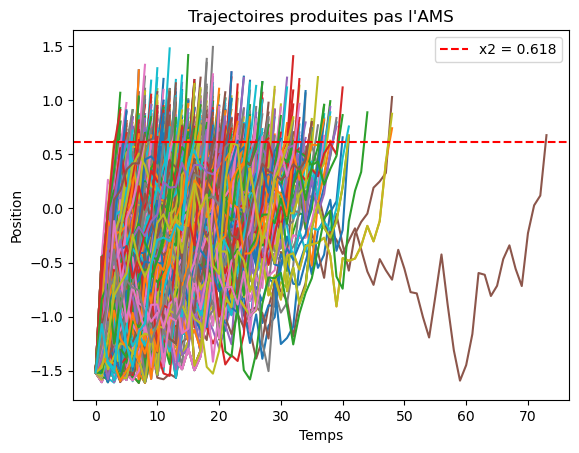

In [12]:
# variables
M = int(1e3)
X0 = x1 + 0.1
trajectoires = []
I_q = []
K_q = 0
sigma = np.sqrt(2*epsilon*h)
p_estim = 1

# simulation initiale
trajectoires = [simulation_trajectoire(X0, h, sigma) for _ in range(M)]
K_q = K(trajectoires)
I_q = I(trajectoires, K_q)

while K_q < x2:

    # (i) Branchement
    indices = list(set(range(M)) - set(I_q))
    for m in I_q:
        p = np.random.choice(indices)
        idx = np.where(trajectoires[p] > K_q)[0][0]
        trajectoires[m] = np.concatenate((trajectoires[p][:idx], simulation_trajectoire(trajectoires[p][idx], h, sigma)))

    # (ii) Calcul du niveau
    K_q = K(trajectoires)
    I_q = I(trajectoires, K_q)

longueurs = [len(traj) for traj in trajectoires]
for i in range(len(longueurs)):
    plt.plot(np.arange(longueurs[i]), trajectoires[i])

plt.axhline(x2, color='r', linestyle='--', label=f'x2 = {round(x2, 3)}')

plt.title("Trajectoires produites pas l'AMS")
plt.xlabel("Temps")
plt.ylabel("Position")
plt.legend()
plt.show()

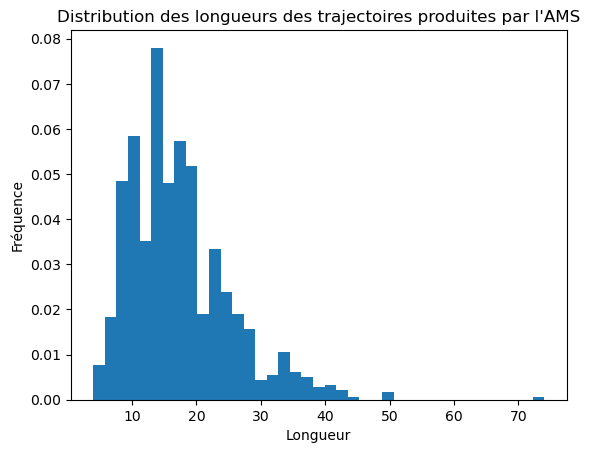

In [13]:
plt.hist(longueurs, bins='auto', density=True)
plt.title("Distribution des longueurs des trajectoires produites par l'AMS")
plt.xlabel("Longueur")
plt.ylabel("Fréquence")
plt.show()

### Question 3 ###

Calcul par méthode Monte-Carlo naïve du temps de transition $T_{12}$ :

In [14]:
def simulation_trajectoire_long(X0, h, sigma, K):
    # simulation d'une trajectoire longue 
    Xn = X0
    traj = [X0]
    for i in range(K):
        Xn = Xn - Vprime(Xn)*h + sigma*np.random.randn()
        traj.append(Xn)
    return np.array(traj)

# renvoit les indices des passages aux frontières a et b par la trajectoire
def time_traj(trajectoire,a,b):
    n = len(trajectoire)
    previous  = True 
    borders_idx = []
    for i in range(n):
        if previous:
            if trajectoire[i]>b and trajectoire[i-1]<b:
                borders_idx.append(i)
                previous = False
        if not previous:
            if trajectoire[i]<a and trajectoire[i-1]>a:
                borders_idx.append(i)
                previous = True

    return borders_idx

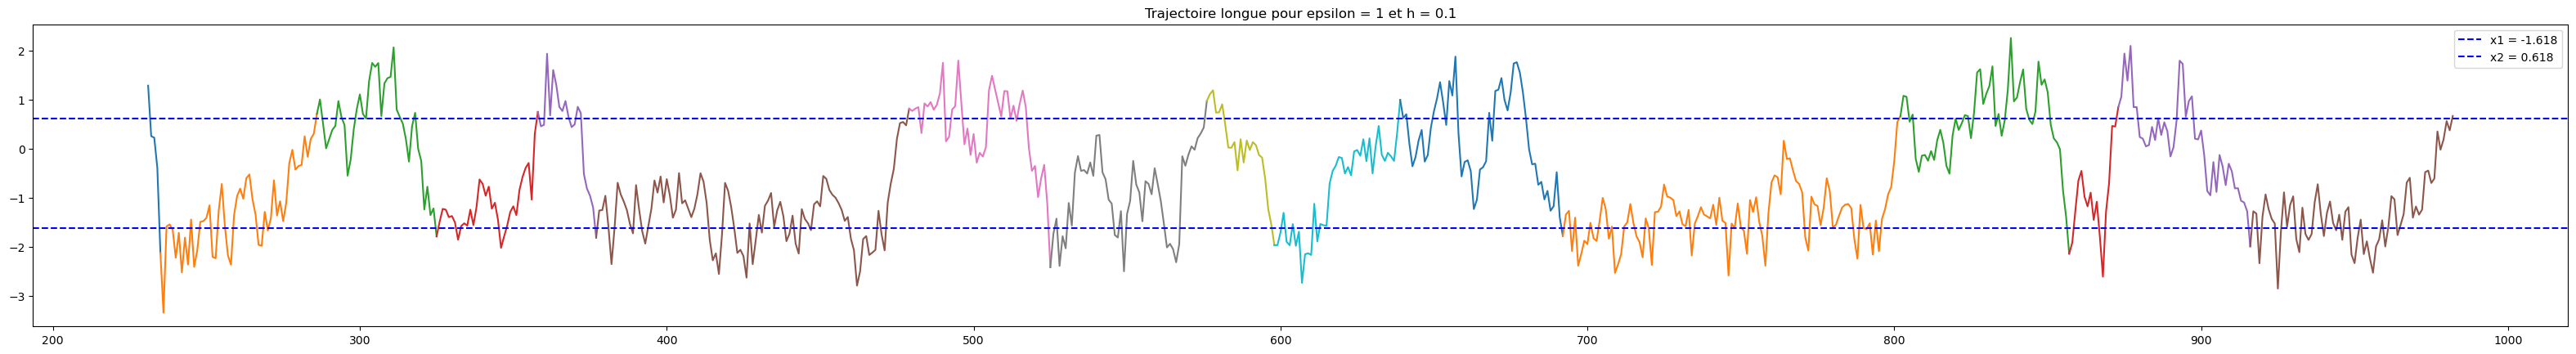

Estimation du temps de transition : 46.9375


In [15]:
epsilon = 1
h = 0.1
KN = int(1e3)


trajectoire = simulation_trajectoire_long(x1,h,np.sqrt(2*h*epsilon),KN)
border_control = time_traj(trajectoire,x1,x2)
transition_times = [border_control[i+1] - border_control[i] for i in range(len(border_control)-1)] # temps entre chaque passage aux frontières opposées
moyenne = np.mean(np.array(transition_times))
trajectoire_transition = [trajectoire[border_control[i]:border_control[i+1]+1] for i in range(len(border_control)-1)]

fig, ax = plt.subplots()

for i in range(len(trajectoire_transition)):
    x_axis = np.linspace(border_control[i],border_control[i+1],len(trajectoire_transition[i]))
    ax.plot(x_axis,trajectoire_transition[i])
    
ax.axhline(x1, color='b', linestyle='--', label=f'x1 = {round(x1, 3)}')
ax.axhline(x2, color='b', linestyle='--', label=f'x2 = {round(x2, 3)}')
ax.set_title(f"Trajectoire longue pour epsilon = {epsilon} et h = {h}")
ax.legend()
fig.set_figwidth(40)

plt.show()

print(f"Estimation du temps de transition : {moyenne}")

Evolution de $T_{12}$ en fonction du parmètre $\epsilon$ :

/usr/local/Caskroom/miniconda/base/envs/MAP/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/Caskroom/miniconda/base/envs/MAP/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


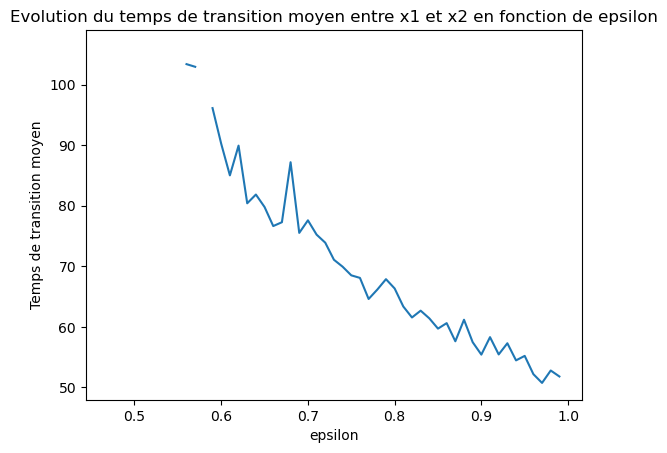

In [16]:
h=0.1
n=int(1e3)
temps_moy_array = []
temps_moy = []

epsilons = [0.01*i for i in range(1,100)]
for _ in range(100):
    for e in epsilons:
        trajectoire = simulation_trajectoire_long(x1,0.1,np.sqrt(2*h*e),n)
        border_control = time_traj(trajectoire,x1,x2)
        transition_times = [border_control[i+1] - border_control[i] for i in range(len(border_control)-1)]
        temps_moy.append(np.mean(transition_times))

    temps_moy_array.append(temps_moy)
    temps_moy = []

temps_moy_array = np.array(temps_moy_array)
temps_moy = np.mean(temps_moy_array,axis=0)

plt.plot(epsilons,temps_moy)
plt.title("Evolution du temps de transition moyen entre x1 et x2 en fonction de epsilon")
plt.xlabel("epsilon")
plt.ylabel("Temps de transition moyen")
plt.show()

### Question 4 ###

Pour aller de $x_1$ à $x_2$, la particule doit forcément passer par $x_0$. On peut donc décomposer la trajectoire en deux étapes. D'abord le passage de $x_1$ à $x_0$ puis le passage de $x_0$ à $x_2$. On pourrait ainsi être tenté d'écrire :
$ \\ T_{12}=\mathbb{E}[T_{10}]+\mathbb{E}[T_{02}] \\$
Or rien n'assure que la particule une fois arrivée en $x_0$ continue directement sa trejectoire vers $x_2$ ce qui rend ce terme difficilement estimable. En l'occurrence, ici on sait que la particule va faire plusieurs allers-retours entre $x_1$ et $x_0$ avant d'éventuellement arriver en $x_2$. On peut donc améliorer la formule en considérant la trajectoire différemment. 

D'abord la particule fait des allers-retours entre $x_1$ et $x_0$ puis elle passe de $x_1$ à $x_2$ sans repasser par $x_1$. Ainsi, $\mathbb{E}[T_{101}]$ correspond au temps moyen que prend la particule pour faire un aller retour de $x_1$ à $x_0$. Ce temps, il faut le multiplier par le nombre moyen d'aller-retour qu'elle va faire avant de se diriger $x_2$. 

On cosidère l'épreuve de Bernoulli dont le succès correspond à la réalisation : la paticule atteint $x_2$ avant $x_1$. Cette épreuve est alors de paramètre $p=\mathbb{P}^{x_0}(\tau_2<\tau_1)$. Compter le nombre d'allers-retours avant que la particule n'aille vers $x_2$ revient à compter le nombre d'échecs avant le premier succès dans un schéma de Bernoulli. En moyenne ce nombre est l'espérance de la loi géométrique associé de paramètre $p \ soit \ \frac{1}{\mathbb{P}^{x_0}(\tau_2<\tau_1)}$. On retire $1$ à ce nombre parce qu'en fait cette espérance correspond plus précisemment au rang du premier succès. 

On rajoute alors le terme $\mathbb{E}{[T_{102}]}$ qui correspond au temps moyen pris par la particule pour aller de $x_1$ à $x_0$ puis vers $x_2$ sans revenir vers $x_1$ (le temps d'un succès en somme) et on obtient la relation de Hill.

Estimation par méthode de Monte-Carlo naïve de $\mathbb{E}\left( T_{101} \right)$ :

In [78]:
def T101_naif(h, epsilon, N):
    # variables
    global x0
    global x1
    sigma = np.sqrt(2*epsilon*h)
    time = 0

    Xn = x1

    for _ in range(N):
        Xn = x1
        # on attend que x0 soit atteint
        while Xn < x0:
            Xn = Xn - Vprime(Xn)*h + sigma*np.random.randn()
            time += 1
        # puis que x1 soit atteint
        while Xn > x1:
            Xn = Xn - Vprime(Xn)*h + sigma*np.random.randn()
            time += 1
    
    return h*time/N

Estimation par méthode de Monte-Carlo naïve de $\mathbb{E}\left( T_{102} \right)$ :

On commence par la partie de $x_1$ à $x_0$ :

In [79]:
def T10_naif(h, epsilon, N):
    # variables
    global x0
    global x1
    sigma = np.sqrt(2*epsilon*h)
    time = 0

    Xn = x1

    for _ in range(N):
        Xn = x1
        # on attend que x0 soit atteint
        while Xn < x0:
            Xn = Xn - Vprime(Xn)*h + sigma*np.random.randn()
            time += 1
    
    return h*time/N

Puis la partie de $x_0$ à $x_2$ par AMS :

In [80]:
def T02_AMS(X0, M, h, epsilon):
    # variables
    global x2
    trajectoires = []
    I_q = []
    K_q = 0
    sigma = np.sqrt(2*epsilon*h)
    p_estim = 1

    # simulation initiale
    trajectoires = [simulation_trajectoire(X0, h, sigma) for _ in range(M)]
    K_q = K(trajectoires)
    I_q = I(trajectoires, K_q)
    p_estim *= 1 - len(I_q)/M

    while K_q < x2:
        # (i) Branchement
        indices = list(set(range(M)) - set(I_q))
        for m in I_q:
            p = np.random.choice(indices)
            idx = np.where(trajectoires[p] > K_q)[0][0]
            trajectoires[m] = np.concatenate((trajectoires[p][:idx], simulation_trajectoire(trajectoires[p][idx], h, sigma)))

        # (ii) Calcul du niveau
        K_q = K(trajectoires)
        I_q = I(trajectoires, K_q)
        p_estim *= 1 - len(I_q)/M
    
    longueurs = np.array([len(traj) for traj in trajectoires])

    return (h*np.mean(longueurs),p_estim)

On applique la relation de Hill : $T_{12} = \mathbb{E}\left(T_{101}\right)\left(\frac{1}{\mathbb{P}\left(\tau_2 < \tau_1\right)}-1\right) + \mathbb{E}\left(T_{102}\right)$

In [81]:
def Hill(epsilon, h, N, M, k):
    global x1
    global x2

    ET101 = T101_naif(h, epsilon, N)
    print("ET101", ET101)
    ET10 = T10_naif(h, epsilon, N)
    print("ET10", ET10)

    res = np.array([T02_AMS(x1 + 0.1, M, h, epsilon) for _ in range(k)])
    ET02 = np.dot(res.T[0], res.T[1])/np.sum(res.T[1])
    print("ET02", ET02)

    ET102 = ET10 + ET02
    print("ET102", ET102)

    p = np.array([estimateur_AMS(x1 + 0.1, M, h, epsilon) for _ in range(k)]).mean()
    print("p", p)

    return ET101*((1/p) - 1) + ET102

In [1]:
Hill(0.5, 0.001, 10000, 100, 10)

NameError: name 'Hill' is not defined

In [91]:
def T12_naif(h, epsilon, N):
    # variables
    global x0
    global x1
    global x2
    sigma = np.sqrt(2*epsilon*h)
    times = np.zeros(N).astype(int)

    for i in range(N):
        Xn = x1
        # on attend que x2 soit atteint
        while Xn < x2:
            Xn = Xn - Vprime(Xn)*h + sigma*np.random.randn()
            times[i]+=1
    return h*times.mean()

In [93]:
T12_naif(0.01, 0.2, 10000)

498.68795

In [96]:
epsilon = 0.1
2*np.pi*np.exp((V(z) - V(x1))/epsilon)/np.sqrt(abs(Vseconde(z))*Vseconde(x1))

78437.17740714943

Nombre de chiffres significatifs en $1/\sqrt{N}$ !!!!